In [1]:
# General
import pickle
import pandas as pd
import numpy as np
import datetime
from scipy import stats
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# SARIMAX
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error


# Set options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)



In [2]:
# Load data, sort on zip and date and set index to datetime
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f:
    data = pickle.load(f)
data.sort_values(['census_cbsa_geoid', 'census_zcta5_geoid', 'date'])
data.set_index('date', inplace=True)

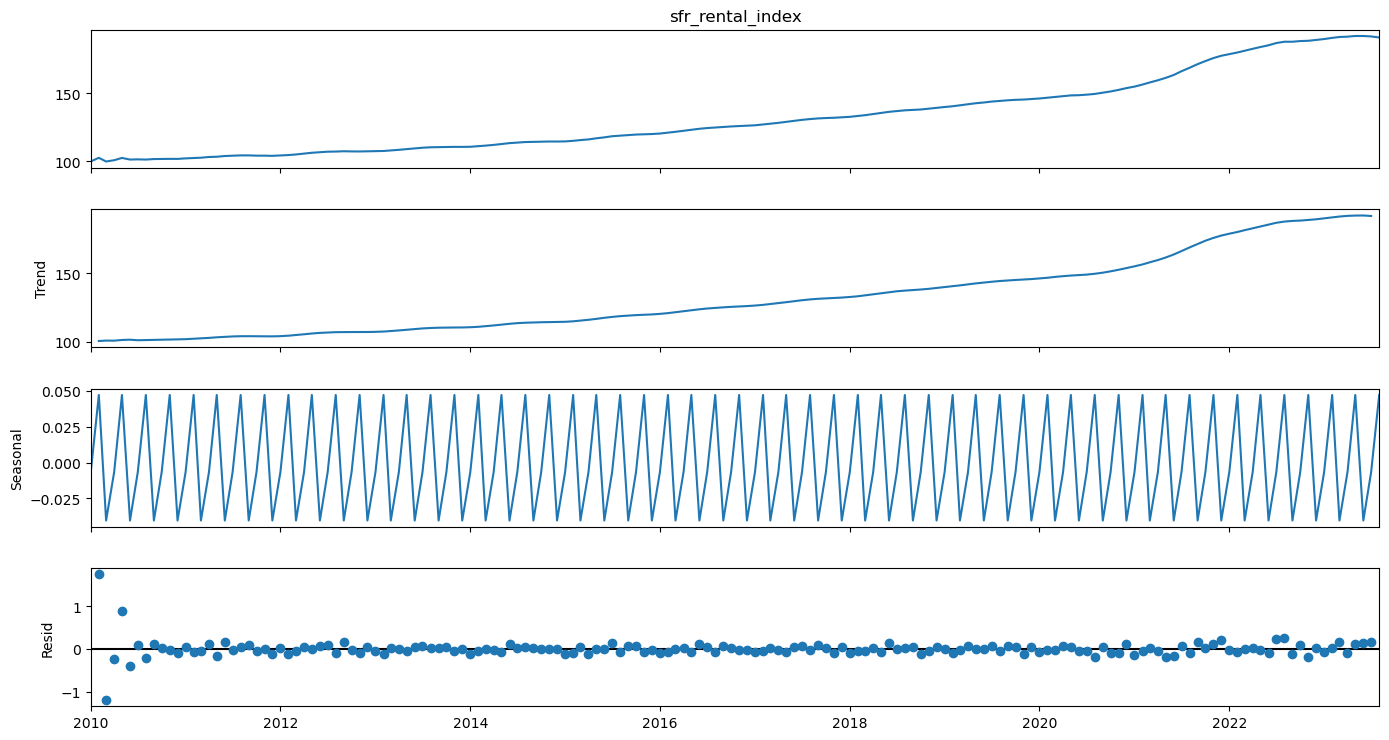

In [3]:
df_sub = data[data['census_zcta5_geoid'] == '30002']

res = sm.tsa.seasonal_decompose(df_sub['sfr_rental_index'].dropna(), period = 3) # by monthly

fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [4]:
#train_test_split
tr_start,tr_end = '2015-01-01','2022-05-01'
te_start,te_end = '2022-06-01','2023-06-01'
tra = df_sub['sfr_rental_index'][tr_start:tr_end].dropna()
tes = df_sub['sfr_rental_index'][te_start:te_end].dropna()


# Select features that are available from 2015 onwards
features = df_sub[['sfr_price_index', 'mfr_mean_rent_index', 'mfr_mean_occ_index']]
#features['census_cbsa_geoid'] = features['census_cbsa_geoid'].astype(int)
#features['census_zcta5_geoid'] = features['census_zcta5_geoid'].astype(int)

exog_train=features.iloc[:,0:][tr_start:tr_end]
exog_test = features.iloc[:, 0:][te_start:te_end]

In [5]:
tra.head()

date
2015-01-01    114.715608
2015-02-01    115.155485
2015-03-01    115.694032
2015-04-01    116.181280
2015-05-01    117.000157
Name: sfr_rental_index, dtype: float64

In [6]:
# Check stationarity (not stationary)
#Time series are stationary if they do not have trend or seasonal effects. 
# Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.

#ADF-test(Original-time-series)
# If we fail to reject null hypothesis (Null Hypothesis (H0): alpha=1), the time series is non-stationary - this is rather obvious from the plots above
res = sm.tsa.adfuller(tra.dropna(),regression='ctt')
print('p-value:{}'.format(res[1]))

#ADF-test(differenced-time-series)
res = sm.tsa.adfuller(tra.diff().dropna(),regression='c')
print('p-value:{}'.format(res[1]))

# NEITHER THE RAW DATA OR THE DIFFERENCE DATA ARE STATIONARY

p-value:0.12253743698465946
p-value:0.7826760136448251


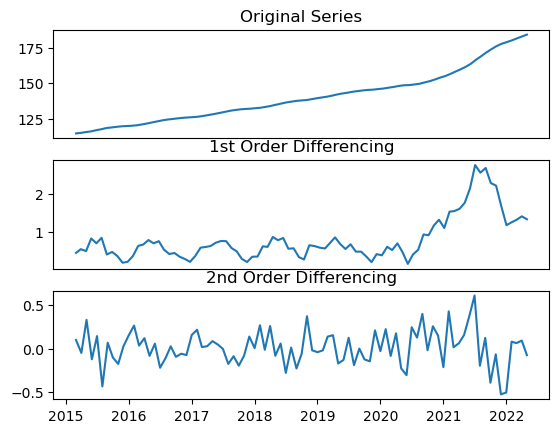

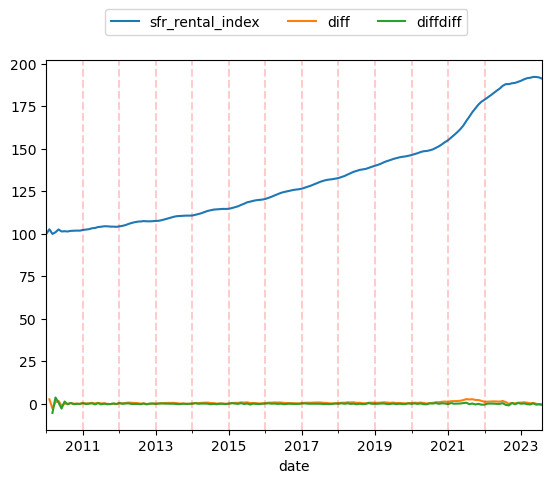

In [7]:
# Finding the appropriate order of differencing (d parameter in ARIMA). 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(tra); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(tra.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(tra.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

# Here 1st order differencing seems to be the best as the trend is mostly removed and the time series appears stationary
# 2nd order differencing is probably over differencing but we will confirm with autocorrelation plots below

# ALSO to see how trend is removed and data become stationary
#acf -> remove trend 
df_sub["diff"] = df_sub['sfr_rental_index'].diff()
df_sub['diffdiff'] = df_sub['sfr_rental_index'].diff().diff()
tmp = df_sub[['sfr_rental_index', 'diff', 'diffdiff']]
ax = tmp.plot()
ax.legend(ncol=5, 
          loc='upper center',
          bbox_to_anchor=(0.5, 1.0),
          bbox_transform=plt.gcf().transFigure)
for yr in range(2010, 2023):
    ax.axvline(pd.to_datetime(str(yr)+"-01-01"), color ="red", linestyle = "--", alpha = 0.2)

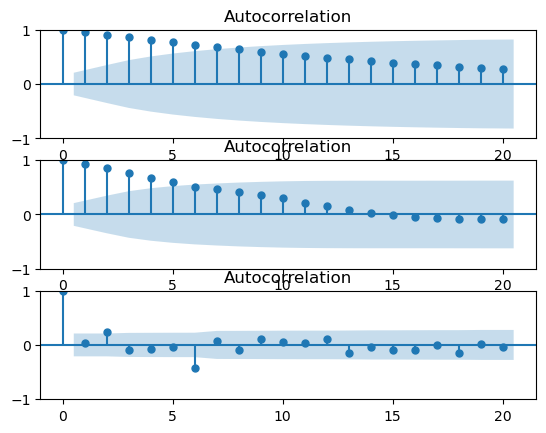

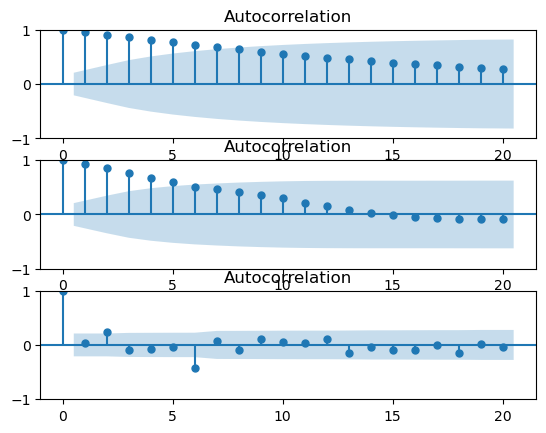

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(tra, ax=ax1)
plot_acf(tra.diff().dropna(), ax=ax2)
plot_acf(tra.diff().diff().dropna(), ax=ax3)

# Final decision: 1st order differencing

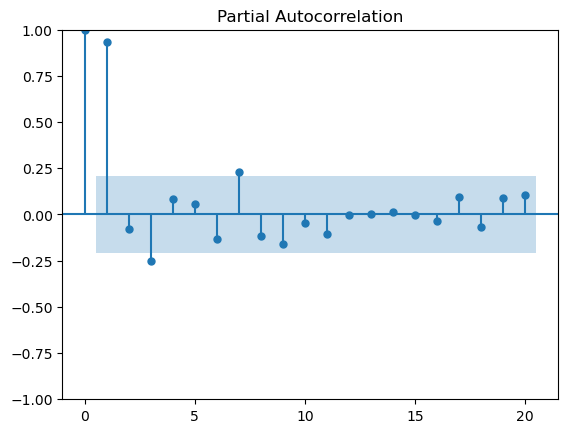

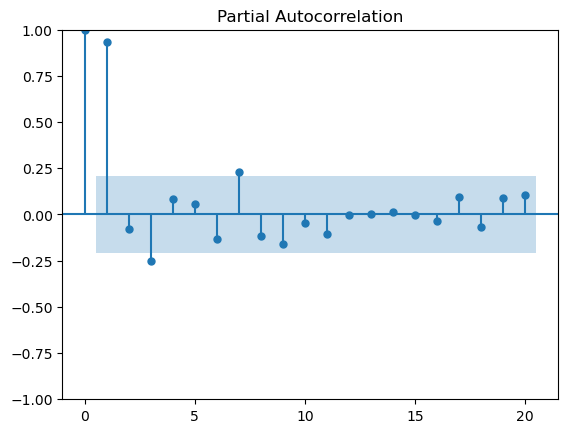

In [9]:
#The partial autocorrelation function plot can be used to draw a correlation 
# between the time series and its lag while the contribution from intermediate lags can be ignored.
# Significant correlation in a stationary time series can be represented by adding auto regression terms. 
# Using the PACF plot we can take the order of AR terms to be equal to the lags that can cross a significance limit. 
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(tra.diff().dropna())

# Select order of p = 1 (1 significant lag)

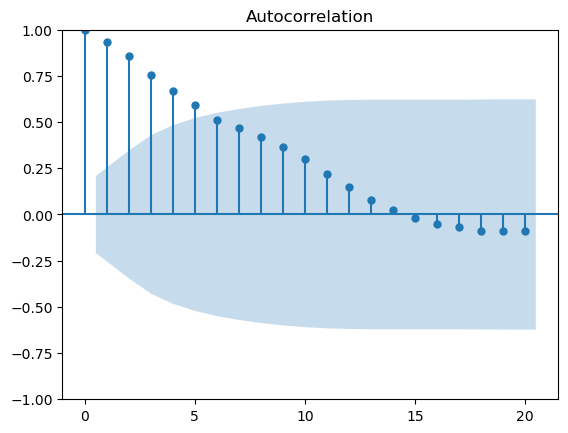

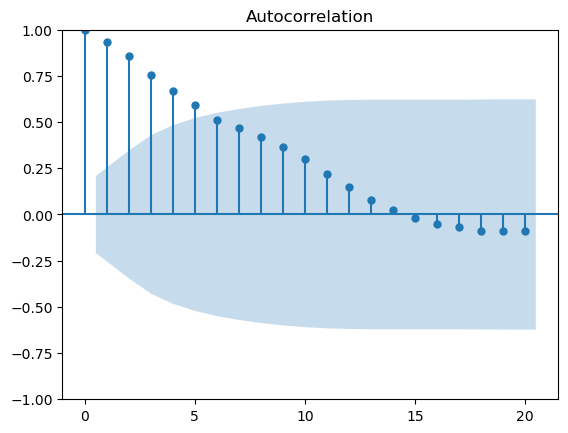

In [10]:
# Determine q parameter (the size of the moving average window required to remove autocorrelation)
plot_acf(tra.diff().dropna())

# q = 6

In [11]:
# Estimate the best value for P parameter - the number of autoregressive terms
resDiff = sm.tsa.arma_order_select_ic(tra.diff(), max_ar=4, max_ma=4, ic='aic', trend='c')


/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/eihwood/opt/miniforge3/lib/py

In [12]:
#p is the number of autoregressive terms, (3)
#d is the number of nonseasonal differences, (1)
#q is the number of lagged forecast errors in the prediction equation (5)

print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (3, 4) is the best.


In [13]:
# FIT ARIMA WITH NO SEASONAL COMPONENTS
arima = sm.tsa.statespace.SARIMAX(tra,
                                  order=(3,1,4), 
                                  seasonal_order=(0,0,0,0),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
arima.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93612D-01    |proj g|=  1.06484D-01

At iterate    5    f= -2.05436D-01    |proj g|=  3.39486D-02

At iterate   10    f= -2.09949D-01    |proj g|=  5.85228D-02

At iterate   15    f= -2.21606D-01    |proj g|=  1.92406D-01

At iterate   20    f= -2.48381D-01    |proj g|=  2.76721D-02

At iterate   25    f= -2.49136D-01    |proj g|=  2.04642D-02

At iterate   30    f= -2.49744D-01    |proj g|=  2.44131D-02

At iterate   35    f= -2.50142D-01    |proj g|=  4.42037D-03

At iterate   40    f= -2.50145D-01    |proj g|=  3.93936D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       sfr_rental_index   No. Observations:                   89
Model:               SARIMAX(3, 1, 4)   Log Likelihood                  22.263
Date:                Wed, 04 Oct 2023   AIC                            -28.526
Time:                        14:25:31   BIC                             -9.175
Sample:                    01-01-2015   HQIC                           -20.752
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7910      0.151      5.245      0.000       0.495       1.087
ar.L2         -0.3723      0.209     -1.781      0.075      -0.782       0.037
ar.L3          0.5242      0.181      2.897      0.004       0.170       0.879
ma.L1          0.3122      0.187      1.667      0.095      -0.055       0.679
ma.L2          1.0171      0.237      4.295      0.000       0.553       1.481
ma.L3          0.0120      0.204      0.059      0.953      -0.387       0.412
ma.L4          0.5614      0.163      3.451      0.001       0.243       0.880
sigma2         0.0330      0.005      6.833      0.000       0.024       0.042
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.87   Prob(JB):                         0.55
Heteroskedasticity (H):               3.19   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Notes on warning: Covariance matrix culculated using the outer product of gradients (complex-step).

- This warning is actually more like a "note" than a "warning". It's just letting you know how the covariance matrix was computed.

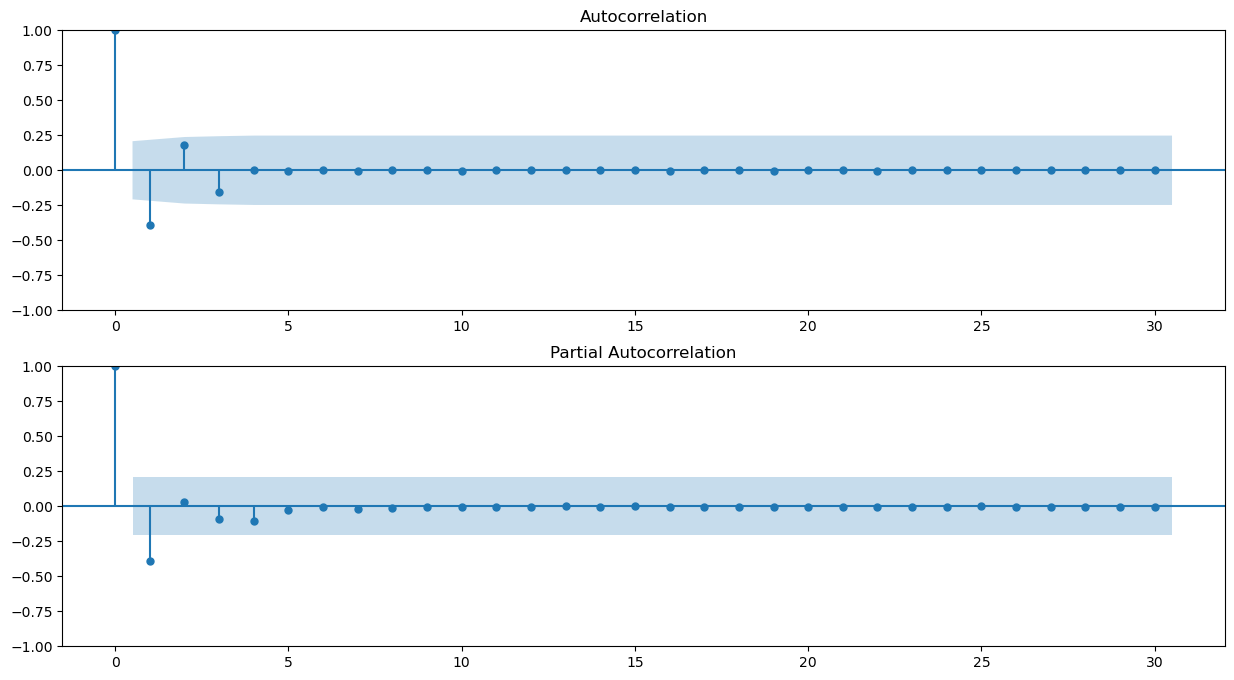

In [14]:


# Check model autocorrelation
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [15]:
pred = arima.predict(tr_end,te_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMA model MSE:16.568785547157876


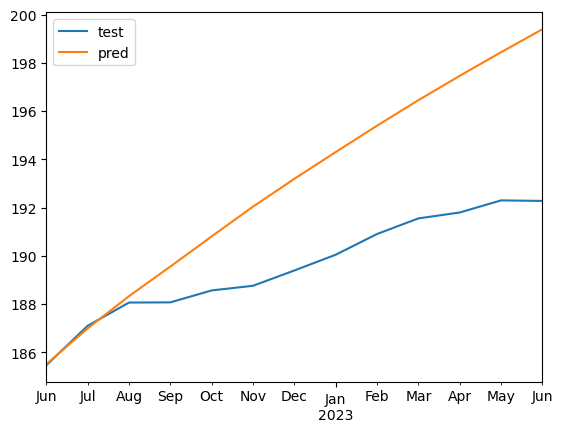

In [16]:
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()


To determine the parameter values for Seasonality we will again use the ACF/PACF plots. Choosing values for each parameter is not a precise exercise, these are rules of thumb and it will take iterations to get the correct model parameters.

 - Seasonal Period (m)
Our seasonal period m, is the number of periods in each season. We can identify this from the ACF and PACF plot where our value m is equal to the lag with the greatest autocorrelation coefficient. The 0 value is always 1 because it has perfect correlation with the current timestep. If our data is seasonal we'd expect that the next most correlated value to the current timestep would be the equivalent point in the season exactly one season ago. The seasonal period value will also help us determine P and Q.

- Seasonal Autoregressive Order (P)
Our seasonal autoregressive order can be thought about just like our autoregressive order except instead of finding the order of past timesteps that influence the value at the current timestep, we are looking for past timesteps on the order of seasons of m, the seasonal period. This is why the mth lag is also used to determine the value of P. If the lag m has a positive value then P should be >= 1. Otherwise P should be 0. We can fit the model with a value of 1 and increment as we see fit.

- Seasonal Difference Order (D)
The rule of thumb for our D parameter is that our series differencing and seasonal differencing should not be greater than 2. If our seasonal pattern is stable overtime then we can set D=1 and set D=0 if the seasonal pattern seems unstable.

- Seasonal Moving Average Order (Q)
We determine Q much like we determine P. If the lag m, is negative then Q >= 1- the opposite of how we fit P. We generally do not want P+Q to exceed 2. We want to keep our parameter values low because there is a high risk to overfit as we use increasingly complex models.

Lambda Value -1.949780848919595


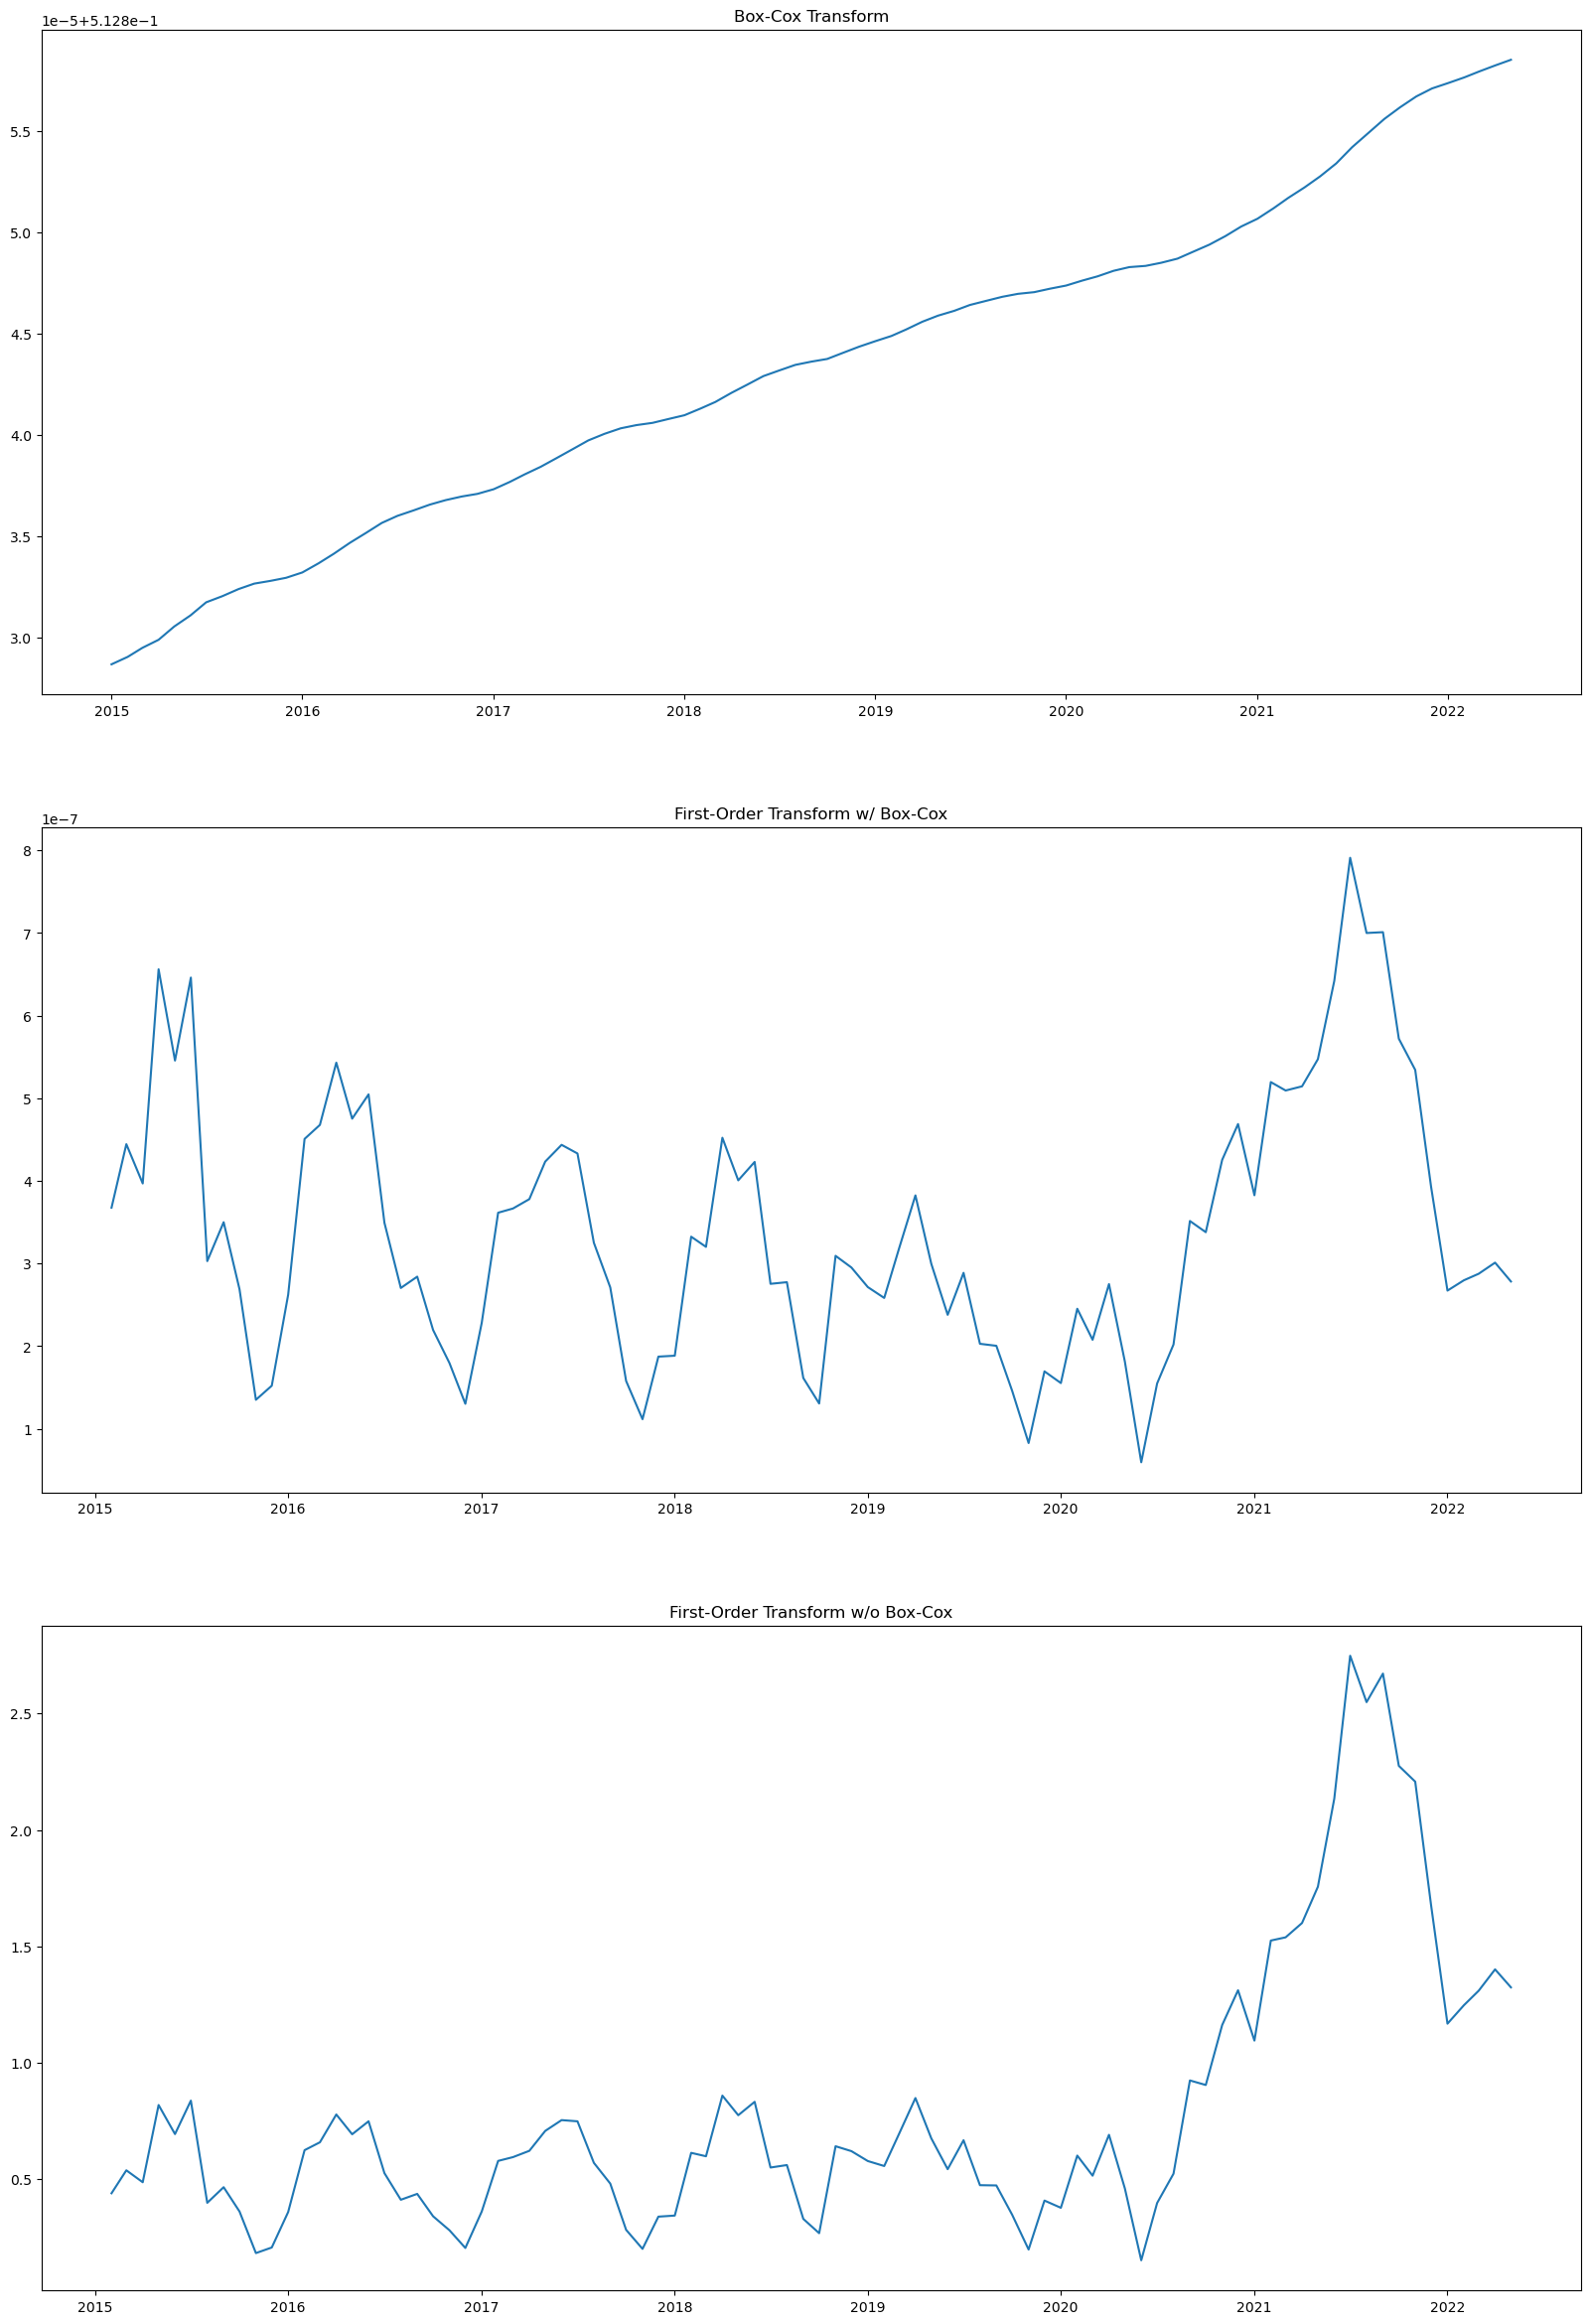

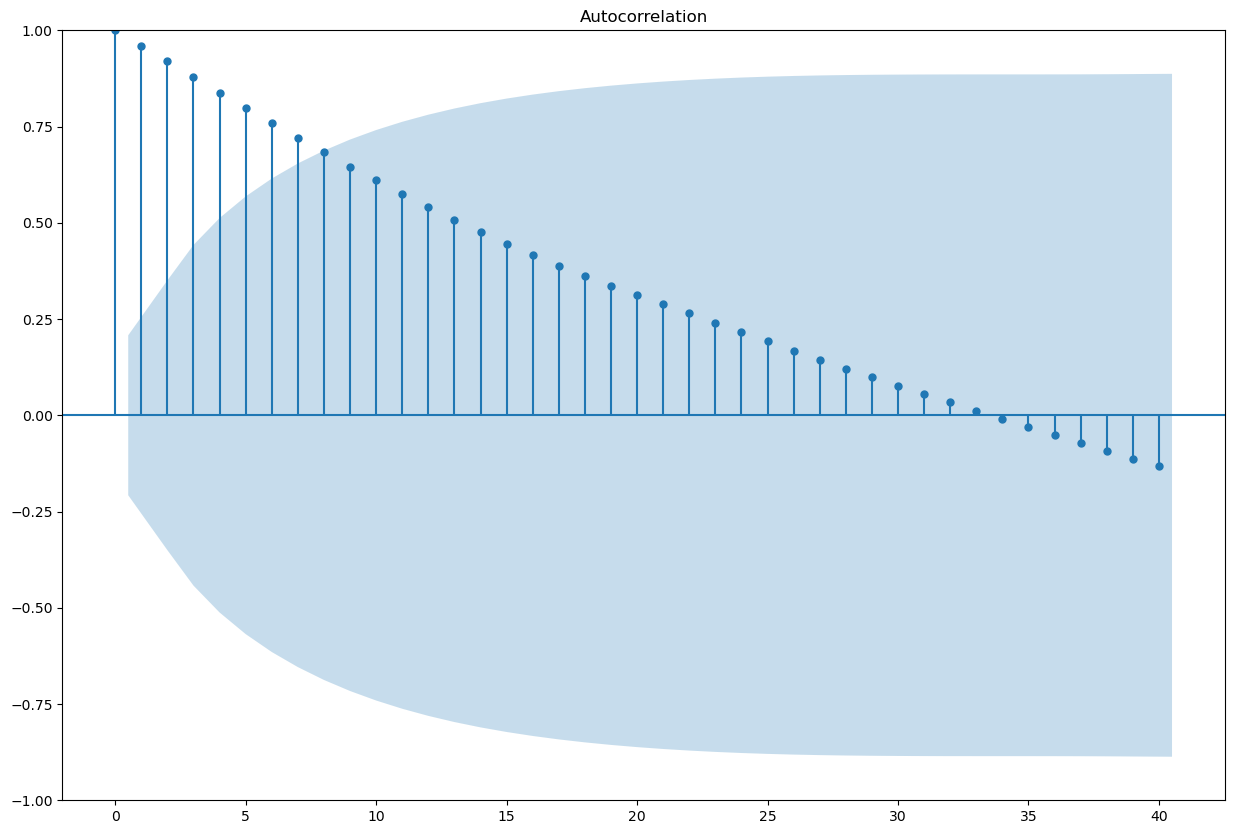

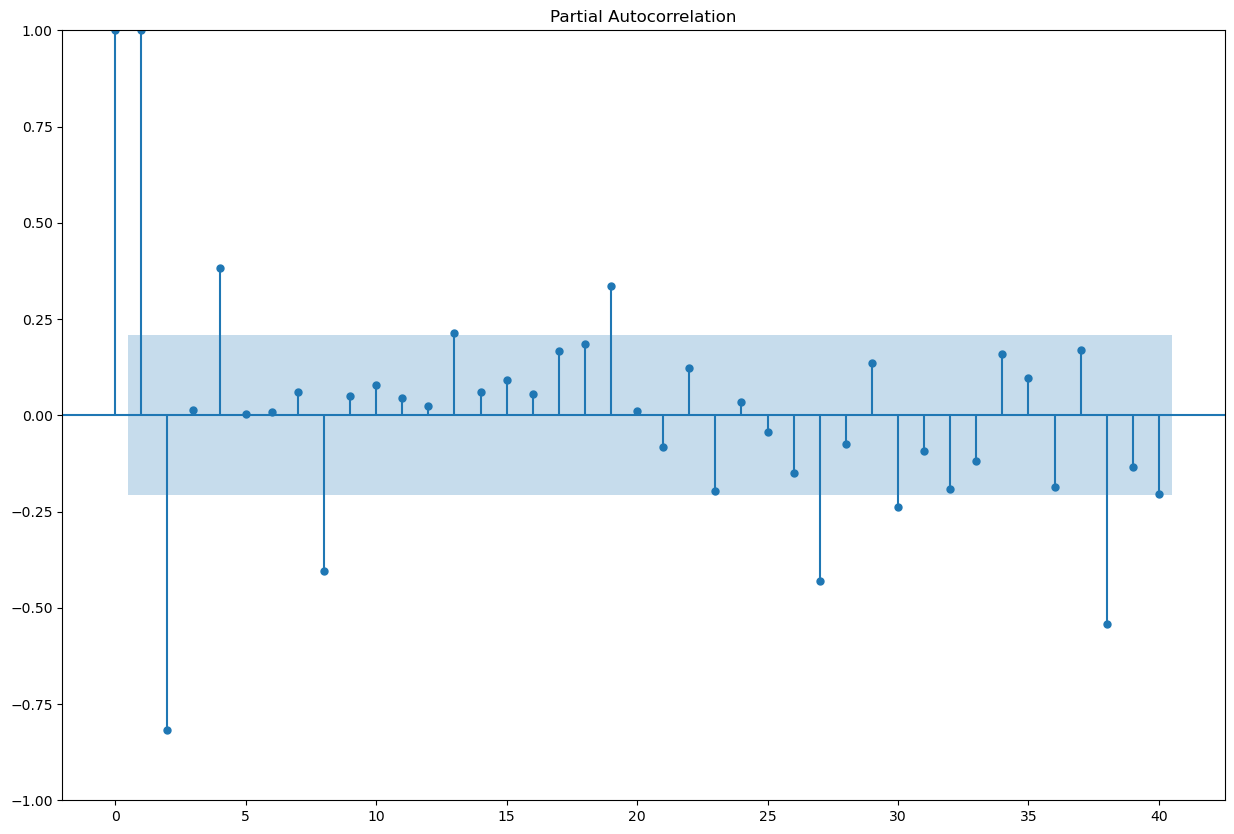

In [17]:
# FIT SEASONAL ARIMA (SARIMA)
## Estimate
#P: Seasonal Autoregressive order
#D: Seasonal difference order
#Q: Seasonal moving average order
#m: The number of time steps for a single seasonal period
# Specified as  SARIMA(p,d,q)(P,D,Q)[m]
df = df_sub[tr_start:tr_end].copy()

df['bc_rpi'], lamb = stats.boxcox(df['sfr_rental_index'])
df['df1_rpi'] = df['bc_rpi'].diff()
df['df_rpi'] = df['sfr_rental_index'].diff()
fig = plt.figure(figsize=(20,40))

bc = plt.subplot(411)
bc.plot(df.bc_rpi)
bc.title.set_text('Box-Cox Transform')
df1 = plt.subplot(412)
df1.plot(df.df1_rpi)
df1.title.set_text('First-Order Transform w/ Box-Cox')
df2 = plt.subplot(413)
df2.plot(df.df_rpi)
df2.title.set_text('First-Order Transform w/o Box-Cox')


print(f'Lambda Value {lamb}')


# M - Our seasonal period m, is the number of periods in each season. 
# We can identify this from the ACF and PACF plot where our value 
# m is equal to the lag with the greatest autocorrelation coefficient. 
# The 0 value is always 1 because it has perfect correlation with the current timestep. 
#If our data is seasonal we'd expect that the next most correlated value to the current timestep would be the equivalent point in the season exactly one season ago. The seasonal period value will also help us determine P and Q.
f_acf = plot_acf(df['bc_rpi'], lags=40)
f_pacf = plot_pacf(df['bc_rpi'], lags=40, method='ols')
f_acf.set_figheight(10)
f_acf.set_figwidth(15)
f_pacf.set_figheight(10)
f_pacf.set_figwidth(15)
plt.show()

In [18]:
sarima = sm.tsa.statespace.SARIMAX(tra,
                                  order=(0,1,4), 
                                  seasonal_order=(3,0,0,3),
                                  enforce_stationarity=False, enforce_invertibility=False).fit()
sarima.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09360D+00    |proj g|=  9.22874D-01

At iterate    5    f= -1.42022D-01    |proj g|=  2.32087D-01

At iterate   10    f= -1.89168D-01    |proj g|=  1.89883D-01

At iterate   15    f= -2.13727D-01    |proj g|=  3.47205D-01

At iterate   20    f= -2.27496D-01    |proj g|=  7.86429D-02

At iterate   25    f= -2.32979D-01    |proj g|=  5.85667D-02

At iterate   30    f= -2.34684D-01    |proj g|=  2.00074D-01

At iterate   35    f= -2.37393D-01    |proj g|=  2.20255D-01

At iterate   40    f= -2.41756D-01    |proj g|=  6.24947D-02

At iterate   45    f= -2.50716D-01    |proj g|=  9.37110D-02

At iterate   50    f= -2.60414D-01    |proj g|=  1.06929D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   sfr_rental_index   No. Observations:                   89
Model:             SARIMAX(0, 1, 4)x(3, 0, [], 3)   Log Likelihood                  23.177
Date:                            Wed, 04 Oct 2023   AIC                            -30.354
Time:                                    14:25:32   BIC                            -11.398
Sample:                                01-01-2015   HQIC                           -22.759
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.5387      0.242      6.369      0.000       1.065       2.012
ma.L2          4.0548      0.942      4.305      0.000       2.209       5.901
ma.L3          3.1311      1.051      2.979      0.003       1.071       5.191
ma.L4          2.5105      1.255      2.001      0.045       0.052       4.969
ar.S.L3        0.9371      0.122      7.696      0.000       0.698       1.176
ar.S.L6       -0.4901      0.156     -3.150      0.002      -0.795      -0.185
ar.S.L9        0.4343      0.123      3.527      0.000       0.193       0.676
sigma2         0.0045      0.003      1.369      0.171      -0.002       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.49   Prob(JB):                         0.16
Heteroskedasticity (H):               5.34   Skew:                             0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(tes,pred)))
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()


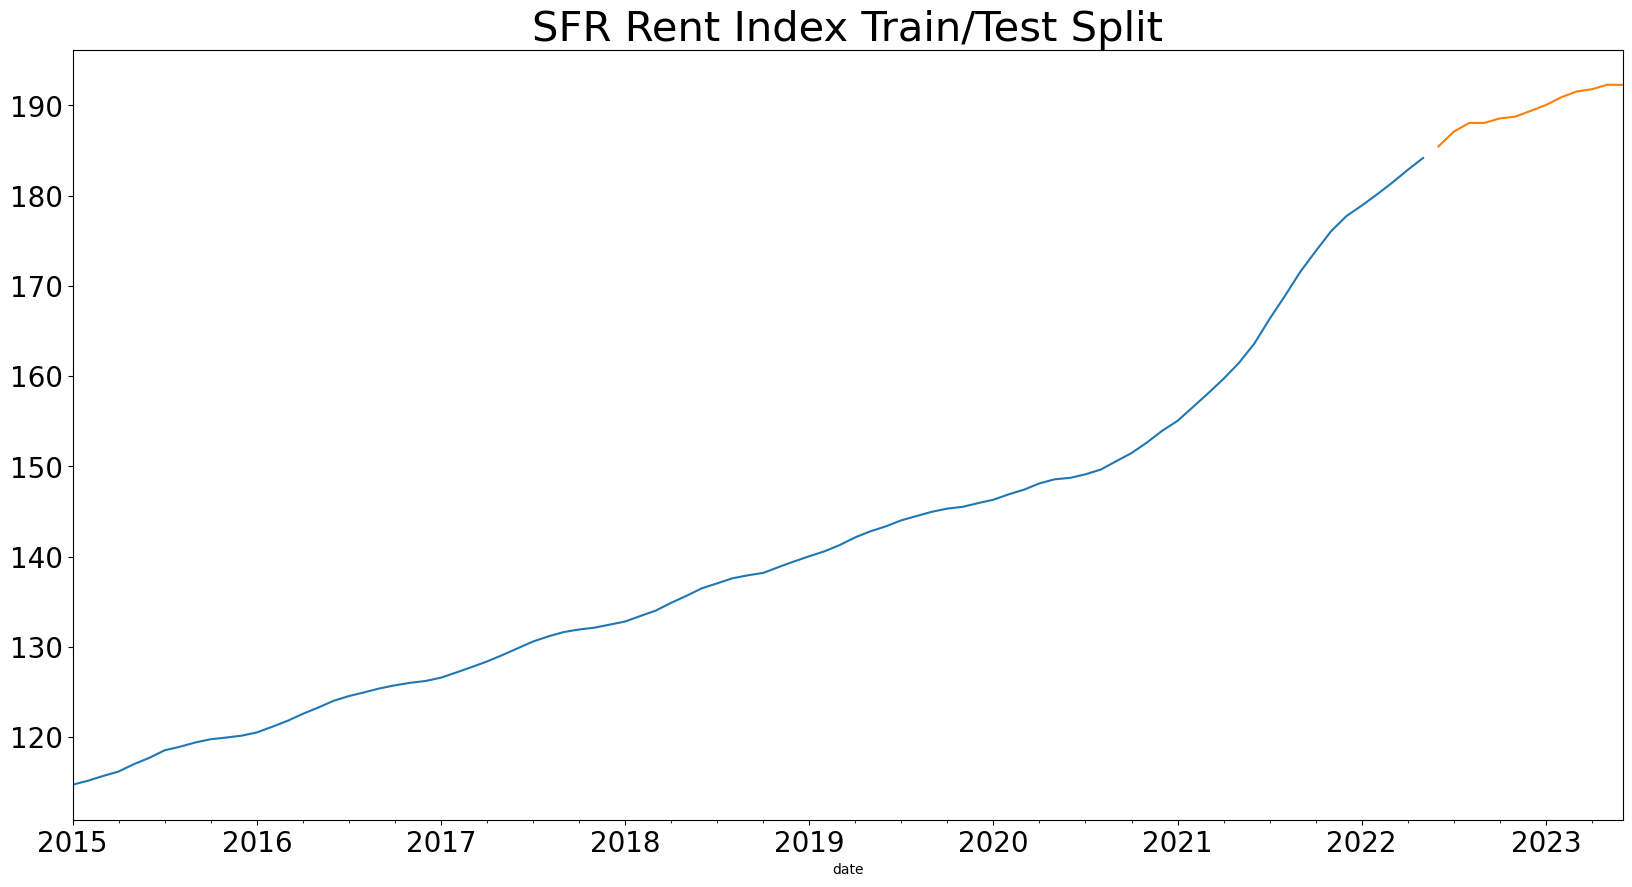

In [19]:
tra.plot(figsize=(20, 10), fontsize=20)
plt.title('SFR Rent Index Train/Test Split', fontsize=30)
tes.plot()
plt.show()

Mean Squared Error: 22.191908432069297
Root Mean Squared Error: 4.710828847673125
Mean Absolute Error: 3.998109660748379


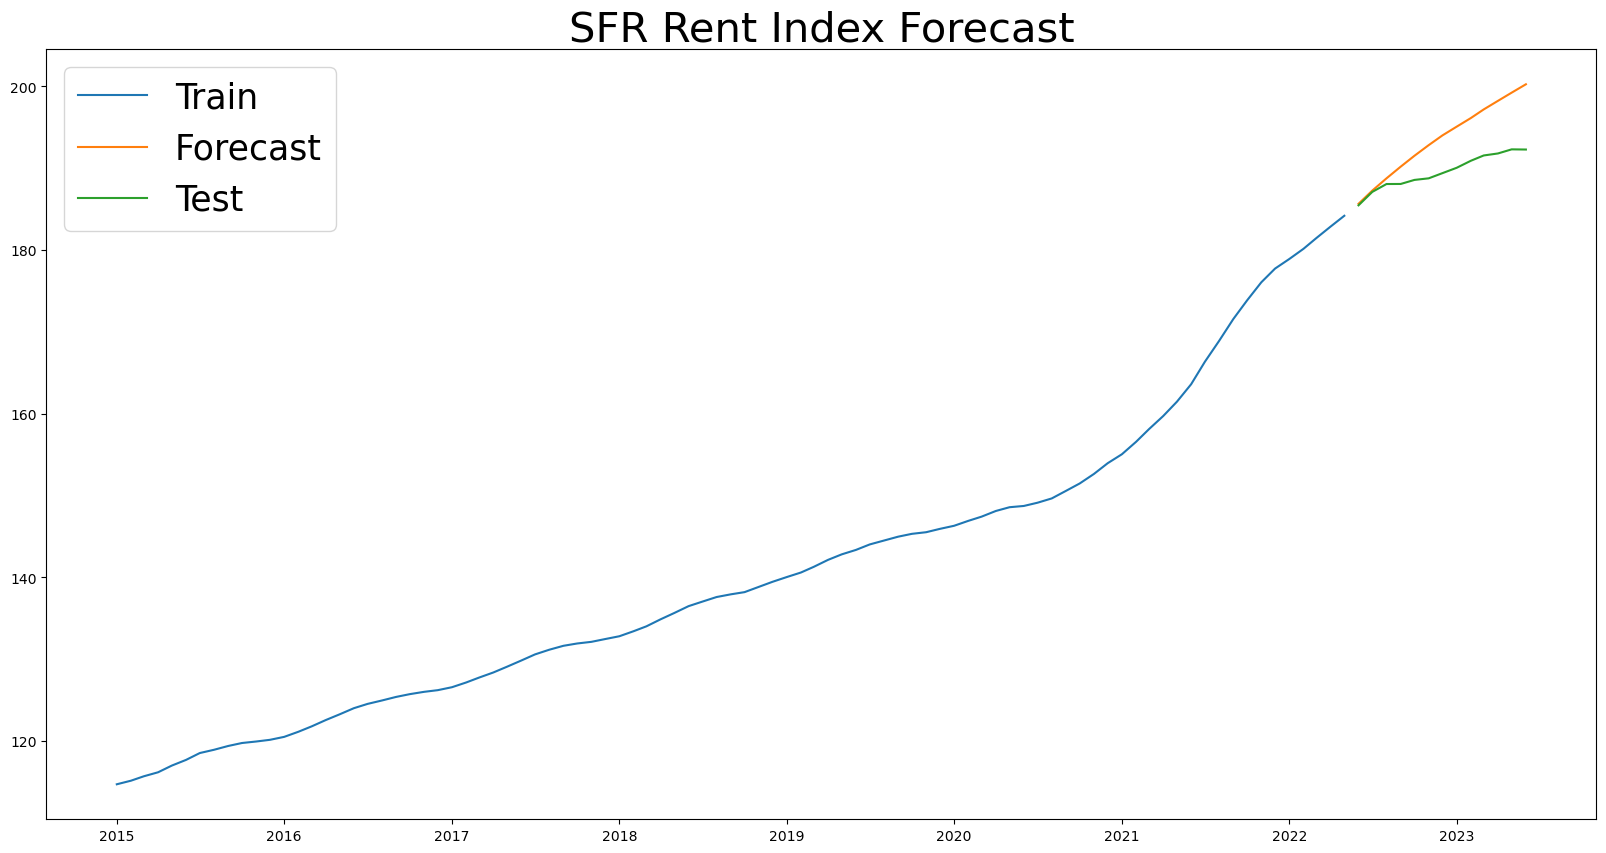

In [20]:
from sklearn.metrics import mean_absolute_error
fcast_len = len(tes)
fcast = sarima.forecast(fcast_len)
mse = mean_squared_error(tes, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(tes, fcast)
plt.figure(figsize=(20, 10))
plt.title('SFR Rent Index Forecast', fontsize=30)
plt.plot(tra, label='Train')
plt.plot(fcast, label='Forecast')
plt.plot(tes, label='Test')

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
plt.legend(fontsize=25)
plt.show()

## NOW WITH EXOGENOUS VARIABLES 

In [46]:
arimax = sm.tsa.statespace.SARIMAX(tra, exog=exog_train,
                                  order=(2,1,2),
                               seasonal_order=(0,0,0,0)).fit()
arimax.summary()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33718D-01    |proj g|=  8.98312D-01

At iterate    5    f=  1.72560D-01    |proj g|=  1.09185D+00

At iterate   10    f= -2.08565D-01    |proj g|=  7.42194D-01

At iterate   15    f= -2.27977D-01    |proj g|=  2.88121D-02

At iterate   20    f= -2.32479D-01    |proj g|=  1.22697D-01

At iterate   25    f= -2.36172D-01    |proj g|=  3.71694D-02

At iterate   30    f= -2.36430D-01    |proj g|=  1.31506D-02

At iterate   35    f= -2.38076D-01    |proj g|=  4.69337D-02

At iterate   40    f= -2.39510D-01    |proj g|=  1.83024D-02

At iterate   45    f= -2.39617D-01    |proj g|=  5.50939D-03

At iterate   50    f= -2.39620D-01    |proj g|=  4.88045D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       sfr_rental_index   No. Observations:                   89
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  21.326
Date:                Wed, 04 Oct 2023   AIC                            -26.652
Time:                        14:37:27   BIC                             -6.834
Sample:                    01-01-2015   HQIC                           -18.668
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
sfr_price_index        -0.0115      0.051     -0.226      0.821      -0.111       0.088
mfr_mean_rent_index    -0.0133      0.006     -2.361      0.018      -0.024      -0.002
mfr_mean_occ_index     -0.0347      0.040     -0.858      0.391      -0.114       0.045
ar.L1                   0.4669      0.192      2.426      0.015       0.090       0.844
ar.L2                   0.4812      0.194      2.482      0.013       0.101       0.861
ma.L1                   0.6915      0.179      3.866      0.000       0.341       1.042
ma.L2                   0.4583      0.095      4.833      0.000       0.272       0.644
sigma2                  0.0345      0.005      6.503      0.000       0.024       0.045
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.55   Prob(JB):                         0.44
Heteroskedasticity (H):               2.67   Skew:                             0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

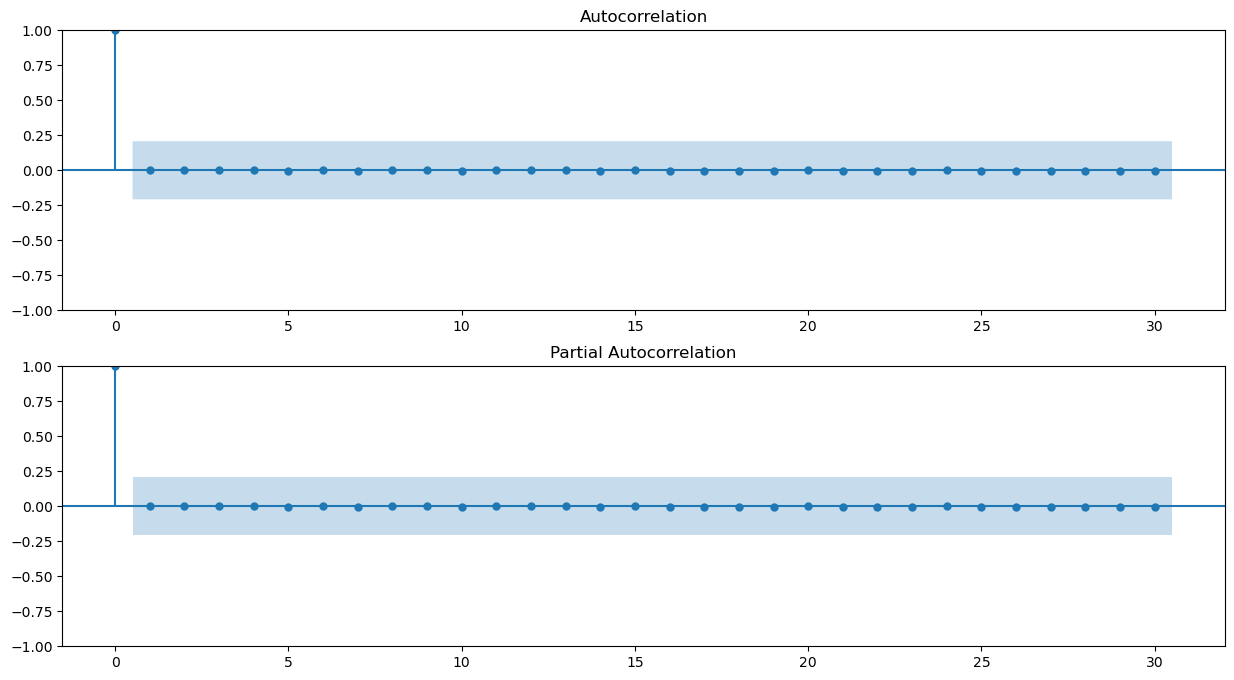

In [48]:
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) .
res = arimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [49]:
pred = arimax.predict(te_start,te_end,exog = exog_test)
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()
arimax.plot_diagnostics(figsize=(15, 12))


ARIMAX model MSE:14.184233821296054


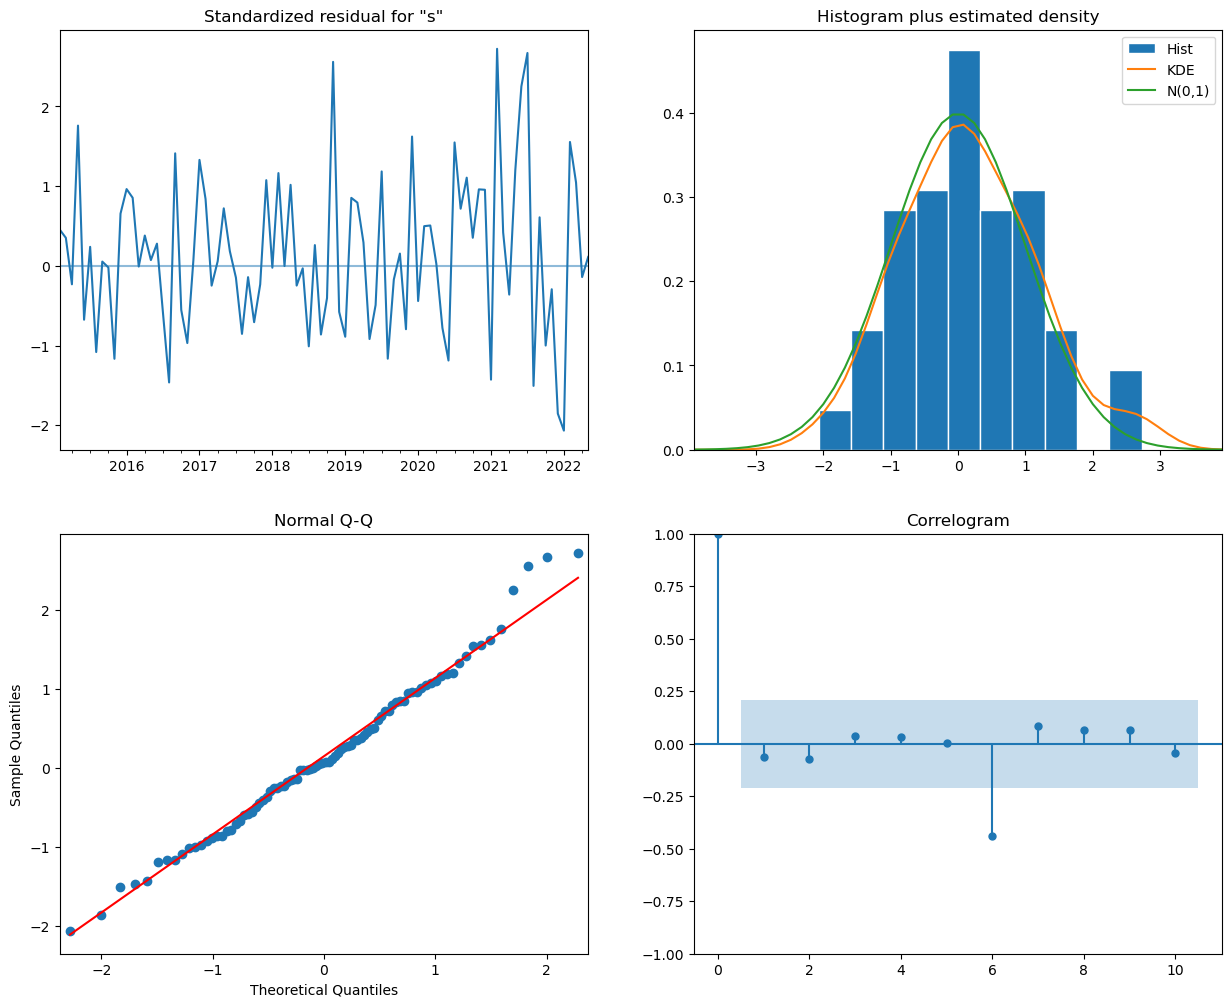

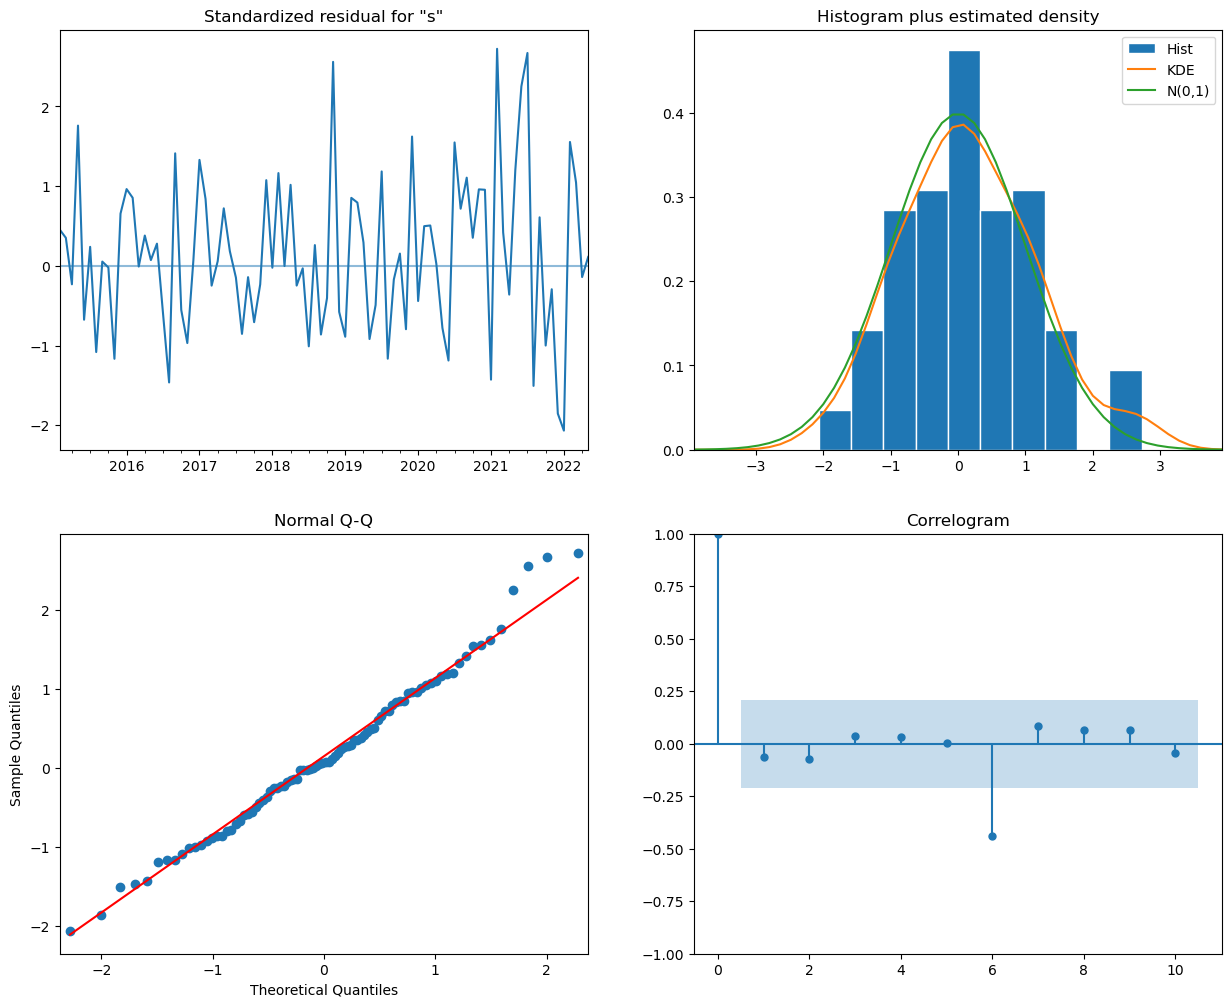

In [57]:
df_sub.columns

Index(['census_cbsa_geoid', 'census_zcta5_geoid', 'sfr_rental_index',
       'sfr_price_index', 'coef', 'nounits', 'occupied_units', 'mfr_occ',
       'mfr_mean_rent', 'mfr_mean_rent_index', 'mfr_mean_occ_index', 'us_zip',
       'population', 'student_population_fraction', 'netflow_estimated',
       'inflow_estimated', 'outflow_estimated', 'cumulative_netflow_estimated',
       'median_income_inflow', 'median_income', 'median_income_difference',
       'median_age_inflow', 'median_age', 'median_age_difference',
       'inflow_index', 'outflow_index', 'netflow_index', 'income_inflow_index',
       'income_diff_index', 'age_inflow_index', 'age_inflow_diff_index',
       'diff', 'diffdiff'],
      dtype='object')

In [62]:
#train_test_split for migration
tr_start,tr_end = '2018-12-01','2022-05-01'
te_start,te_end = '2022-06-01','2023-06-01'
tra = df_sub['sfr_rental_index'][tr_start:tr_end].dropna()
tes = df_sub['sfr_rental_index'][te_start:te_end].dropna()


# Select features that are available from 2015 onwards
features = df_sub.iloc[:,3:-2]
features.drop(columns = 'us_zip', inplace = True)
#features['census_cbsa_geoid'] = features['census_cbsa_geoid'].astype(int)
#features['census_zcta5_geoid'] = features['census_zcta5_geoid'].astype(int)

exog_train=features.iloc[:,0:][tr_start:tr_end]
exog_test = features.iloc[:, 0:][te_start:te_end]

In [64]:
arimax = sm.tsa.statespace.SARIMAX(tra, exog=exog_train,
                                  order=(2,1,2),
                               seasonal_order=(0,0,0,0)).fit(disp = False)
arimax.summary()


/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/eihwood/opt/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       sfr_rental_index   No. Observations:                   42
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -17.883
Date:                Wed, 04 Oct 2023   AIC                             99.767
Time:                        14:50:10   BIC                            154.601
Sample:                    12-01-2018   HQIC                           119.734
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
sfr_price_index                  1.1247      0.216      5.199      0.000       0.701       1.549
coef                           -11.7528      6.575     -1.788      0.074     -24.639       1.133
nounits                      -4.927e-10      0.857  -5.75e-10      1.000      -1.679       1.679
occupied_units                   2.8271      2.454      1.152      0.249      -1.983       7.637
mfr_occ                          0.0038      0.003      1.152      0.249      -0.003       0.010
mfr_mean_rent                   -0.0347      0.034     -1.005      0.315      -0.102       0.033
mfr_mean_rent_index              0.2988      0.365      0.818      0.413      -0.417       1.015
mfr_mean_occ_index             -19.4321     17.267     -1.125      0.260     -53.274      14.410
population                    9.054e-12      7.515    1.2e-12      1.000     -14.729      14.729
student_population_fraction  -5.054e-13    7.7e-05  -6.57e-09      1.000      -0.000       0.000
netflow_estimated                0.0041      0.016      0.254      0.800      -0.028       0.036
inflow_estimated                 0.0034      0.015      0.226      0.821      -0.026       0.033
outflow_estimated               -0.0007      0.018     -0.038      0.970      -0.037       0.035
cumulative_netflow_estimated    -0.0083      0.009     -0.931      0.352      -0.026       0.009
median_income_inflow            46.0181     47.473      0.969      0.332     -47.027     139.063
median_income                -2.182e-14     90.606  -2.41e-16      1.000    -177.584     177.584
median_income_difference       -46.0181     47.473     -0.969      0.332    -139.063      47.027
median_age_inflow               -0.0063      0.045     -0.140      0.889      -0.094       0.082
median_age                   -1.138e-17      0.047  -2.41e-16      1.000      -0.093       0.093
median_age_difference           -0.0063      0.024     -0.258      0.796      -0.054       0.041
inflow_index                  7.592e-05      0.001      0.147      0.883      -0.001       0.001
outflow_index                -9.425e-06      0.000     -0.019      0.985      -0.001       0.001
netflow_index                   -0.0001        nan        nan        nan         nan         nan
income_inflow_index              0.0008      0.001      1.053      0.293      -0.001       0.002
income_diff_index                0.0019      0.002      0.976      0.329      -0.002       0.006
age_inflow_index                -0.0002      0.001     -0.182      0.855      -0.003       0.002
age_inflow_diff_index            0.0005      0.002      0.235      0.814      -0.004       0.005
ar.L1                            0.5621      2.332      0.241      0.810      -4.008       5.133
ar.L2                            0.2530      1.832      0.138      0.890      -3.339       3.845
ma.L1                           -0.0778      2.337     -0.033      0.973      -4.659       4.503
ma.L2                           -0.2755 

ARIMAX model MSE:5.346751324363528


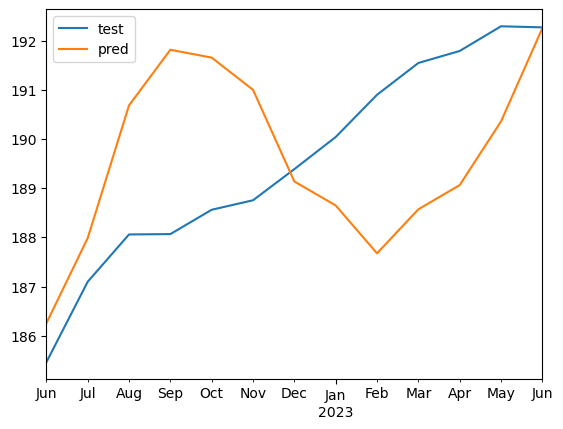

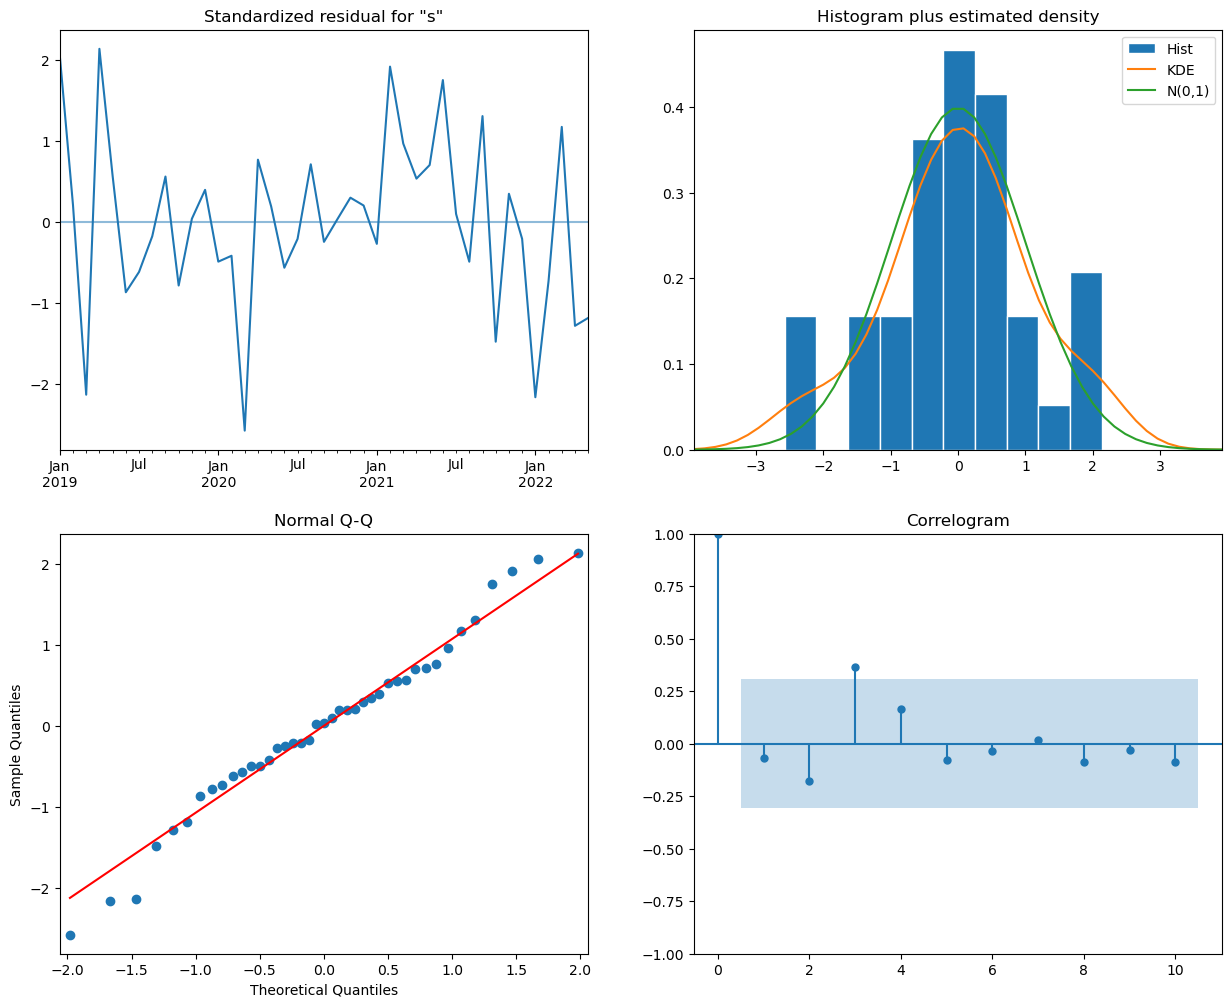

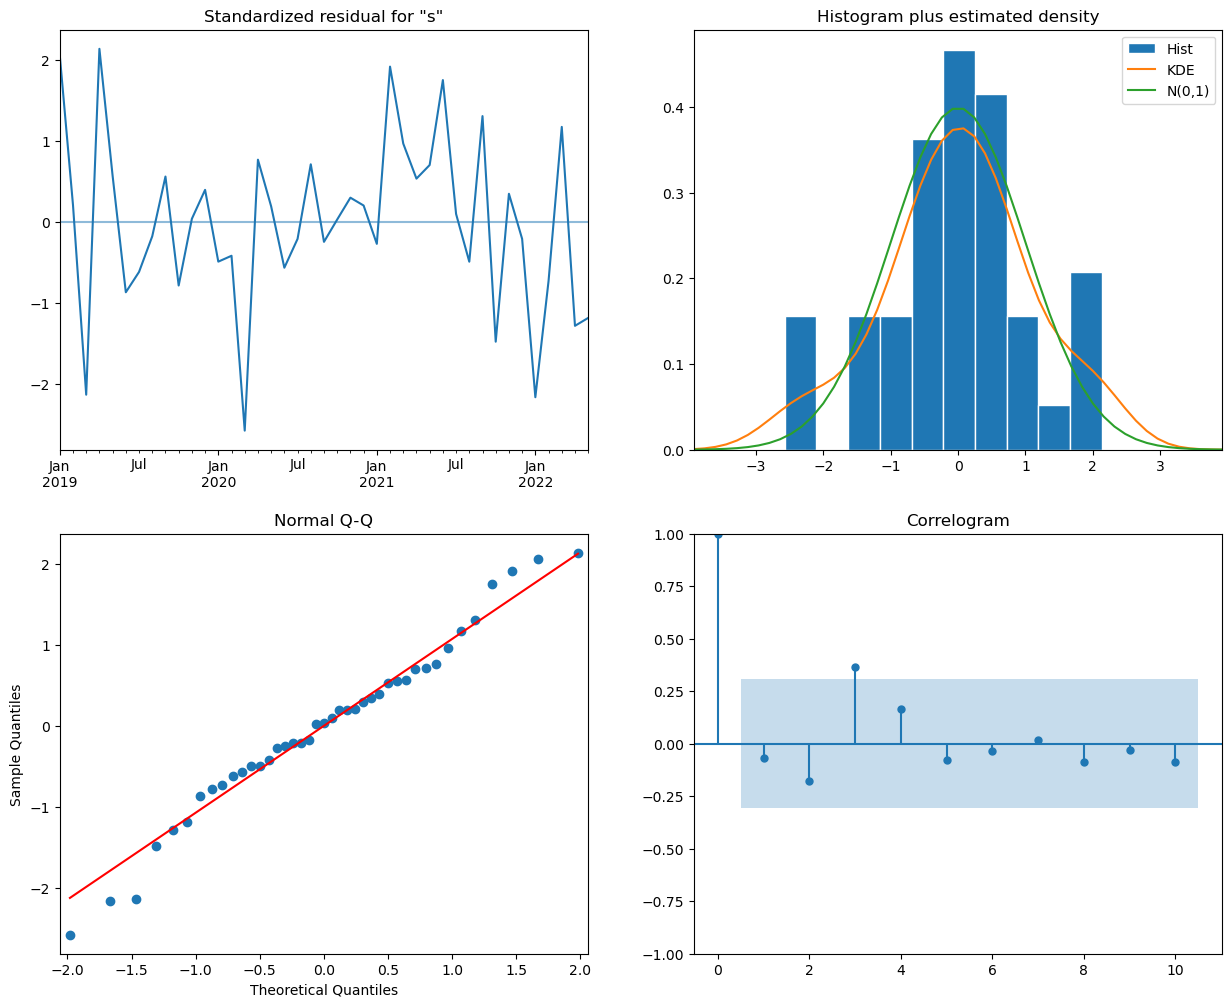

In [65]:
pred = arimax.predict(te_start,te_end,exog = exog_test)
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))
pd.DataFrame({'test':tes,'pred':pred}).plot();plt.show()
arimax.plot_diagnostics(figsize=(15, 12))
